Cross validation evaluation
* returned 10 repeated cv, 5 accuracy scores each, box plot for x_train without pca and with pca

Logistics Regression execution
* austin data set
* rows <= 2023 train, rows > 2023 test
* without pca - RUNS FOR TOO LONG
* with pca - runs

In [ ]:
# Read data set
import pandas as pd
optipaw_data = pd.read_csv('optipaw_FINAL.csv')

# Extract rows where the 'State' column is 'Austin'
austin_data = optipaw_data[optipaw_data['State'] == 'Austin'].copy()

# Reset the index for the Austin data (optional but useful for clean DataFrames)
austin_data.reset_index(drop=True, inplace=True)

# Display the first few rows of the extracted data
print(austin_data.head())

  Animal.ID    Name Animal.Type                        Breed            Sex  \
0   A006100   Scamp         Dog         Spinone Italiano Mix  Neutered Male   
1   A006100   Scamp         Dog         Spinone Italiano Mix  Neutered Male   
2   A047759    Oreo         Dog                    Dachshund  Neutered Male   
3   A134067  Bandit         Dog            Shetland Sheepdog  Neutered Male   
4   A141142  Bettie         Dog  Labrador Retriever/Pit Bull  Spayed Female   

          Color   Age      Intake.Type     Outcome.Type          Intake.Date  \
0  Yellow/White   7.0    Public Assist  Return to Owner  2014-12-19 10:21:00   
1  Yellow/White   6.0    Public Assist  Return to Owner  2014-03-07 14:26:00   
2      Tricolor  10.0  Owner Surrender         Transfer  2014-04-02 15:55:00   
3   Brown/White  16.0    Public Assist  Return to Owner  2013-11-16 09:02:00   
4   Black/White  15.0            Stray  Return to Owner  2013-11-16 14:46:00   

          Outcome.Date   State  
0  2014-12-

In [ ]:
# Preprocessing Function for ML
# change: binary classification of outcome type (adopted = 1, all other types = 0)

import numpy as np
from sklearn.preprocessing import LabelEncoder

def preprocessing(df, name_mapping_var=None):

  # For Name, we will use label encoding to assign each unique name a specific int, at the same time return the mapping
  # Strip leading asterisks from the Name column
  df['Name'] = df['Name'].str.lstrip('*')
  label_encoder = LabelEncoder()
  df['Name'] = label_encoder.fit_transform(df['Name'].astype(str))

  # If the user provided a variable to store the mapping, assign it
  if name_mapping_var is not None:
      name_mapping = {k: v for v, k in enumerate(label_encoder.classes_)}
      name_mapping_var.update(name_mapping)


  # For Animal.Type we will map Int Values to the specific animal type
  animal_mapping = {
    "Dog": 1, "Cat": 2, "Other": 3, "Bird": 4, "Livestock": 5,
    "House Rabbit": 6, "Rat": 7, "Ferret": 8, "Pig": 9, "Hamster": 10,
    "Guinea Pig": 11, "Gerbil": 12, "Hedgehog": 13, "Chinchilla": 14,
    "Goat": 15, "Mouse": 16, "Sugar Glider": 17, "Snake": 18,
    "Wildlife": 19, "Lizard": 20
    }

  df['Animal.Type'] = df['Animal.Type'].map(animal_mapping)

  # For Breed we will perform one hot encoding onto it
  # Remove parentheses and their contents, and replace '/' with space
  df['Breed'] = df['Breed'].str.replace(r'\(.*?\)', '', regex=True).str.replace('/', ' ').str.replace(',', ' ')

  # Split the 'Breed' column into a list and capitalize the first letter of each word
  df['Breed'] = df['Breed'].str.split().apply(lambda breeds: [breed.rstrip('-').capitalize() for breed in breeds])

  # Create dummy variables for each unique breed
  df_breeds = df['Breed'].str.join(' ').str.get_dummies(sep=' ')

  # Concatenate the original dataframe with the one-hot encoded breed dataframe
  df = pd.concat([df, df_breeds], axis=1)

  # Drop the original 'Breed' column
  df = df.drop(columns=['Breed'])

  # For Sex we will map Int Values to specific Sex
  sex_mapping = {'Neutered Male': 1, 'Spayed Female': 2, 'Intact Female': 3, 'Intact Male': 4, 'Unknown': 5, 'Female': 6, 'Male': 7}

  # Map the Sex column using the defined mapping
  df['Sex'] = df['Sex'].map(sex_mapping)

  # For colours, we will split into individual colours and use one hot encoding, which is assigning binary values to it

  # Split the 'Color' column by '/', 'and', and ','
  df['Color'] = df['Color'].str.replace('/', ' ').str.replace('and', ' ').str.replace(',', ' ').str.replace(r'-\b', '', regex=True)

  # Split the 'Color' column into a list and capitalize the first letter of each word
  df['Color'] = df['Color'].str.split().apply(lambda colors: [color.capitalize() for color in colors])

  # Create dummy variables for each unique color
  df_colors = df['Color'].str.join(' ').str.get_dummies(sep=' ')

  # Concatenate the original dataframe with the one-hot encoded color dataframe
  df = pd.concat([df, df_colors], axis=1)

  # Drop the original 'Color' column
  df = df.drop(columns=['Color'])

  # For Age, we will just store it as int and impute it with 0 if it is null, and store it as float
  df['Age'] = df['Age'].fillna(0).astype(float)

  # For Intake.Type, we will map Int Values to specific Intake
  intake_type_mapping = {
      'Public Assist': 1, 'Owner Surrender': 2, 'Stray': 3, 'Euthanasia Request': 4,
      'Abandoned': 5, 'Wildlife': 6, 'Moving': 7, 'Incompatible with owner lifestyle': 8,
      'Rabies Monitoring': 9, 'Marriage/Relationship split': 10, 'Owner Deceased': 11, 'Police Assist': 12,
      'Biting': 13, 'Owner Died': 14, 'TNR - Trap/Neuter/Release': 15, 'Unable to Afford': 16,
      'Unsuitable Accommodation': 17, 'Allergies': 18, 'Transfer from Other Shelter': 19,
      'Born in Shelter': 20, 'Landlord issues': 21, 'Litter relinquishment': 22, 'Sick/Injured': 23,
      'Owner requested Euthanasia': 24, 'Abuse/ neglect': 25, 'Incompatible with other pets': 26,
      'Behavioral Issues': 27, 'DOA': 28
  }

  # Map the Intake.Type column using the defined mapping
  df['Intake.Type'] = df['Intake.Type'].map(intake_type_mapping)

  # Map the Outcome.Type column using the defined mapping (Adopted as 1, all else as 0)
  df['Outcome.Type'] = df['Outcome.Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

  # For Date and Time, we will be using panda and numpy date conversion

  # Convert Intake.Date and Outcome.Date to datetime format
  df['Intake.Date'] = pd.to_datetime(df['Intake.Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
  df['Outcome.Date'] = pd.to_datetime(df['Outcome.Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


  # Extract date components from the date columns
  df['Intake.Day'] = df['Intake.Date'].dt.day.fillna(0).astype(int)
  df['Intake.Month'] = df['Intake.Date'].dt.month.fillna(0).astype(int)
  df['Intake.Year'] = df['Intake.Date'].dt.year.fillna(0).astype(int)

  df['Outcome.Day'] = df['Outcome.Date'].dt.day.fillna(0).astype(int)
  df['Outcome.Month'] = df['Outcome.Date'].dt.month.fillna(0).astype(int)
  df['Outcome.Year'] = df['Outcome.Date'].dt.year.fillna(0).astype(int)

  # Extract and convert the hour to radians
  df['Intake.Hour'] = df['Intake.Date'].dt.hour.fillna(0).astype(int)
  df['Outcome.Hour'] = df['Outcome.Date'].dt.hour.fillna(0).astype(int)

  df['Intake.Hour.Radians'] = (df['Intake.Hour'] / 24) * 2 * np.pi
  df['Outcome.Hour.Radians'] = (df['Outcome.Hour'] / 24) * 2 * np.pi

  # Drop original date columns if no longer needed
  df = df.drop(columns=['Intake.Date', 'Outcome.Date'])

  return df

# Process Austin Dataset (Animal ID and State to be removed later)
austin_data = preprocessing(austin_data)

print(austin_data.head())


  Animal.ID   Name  Animal.Type  Sex   Age  Intake.Type  Outcome.Type   State  \
0   A006100  19560            1    1   7.0            1             0  Austin   
1   A006100  19560            1    1   6.0            1             0  Austin   
2   A047759  16845            1    1  10.0            2             0  Austin   
3   A134067   4665            1    1  16.0            1             0  Austin   
4   A141142   5095            1    2  15.0            3             0  Austin   

   Abyssinian  Affenpinscher  ...  Intake.Day  Intake.Month  Intake.Year  \
0           0              0  ...          19            12         2014   
1           0              0  ...           7             3         2014   
2           0              0  ...           2             4         2014   
3           0              0  ...          16            11         2013   
4           0              0  ...          16            11         2013   

   Outcome.Day  Outcome.Month  Outcome.Year  Intake.Hour

In [ ]:
# Splitting austin_data based on Outcome.Year
train_data = austin_data[austin_data['Outcome.Year'] <= 2023].copy()
test_data = austin_data[austin_data['Outcome.Year'] > 2023].copy()

# Reset the index for both datasets
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Drop 'State' column from both train and test datasets
train_data = train_data.drop(columns=['State'])
test_data = test_data.drop(columns=['State'])

# Extract Animal.ID from the train_data and test_data
train_ids = train_data['Animal.ID']
test_ids = test_data['Animal.ID']

# Drop 'Animal.ID' from train_data and test_data
train_data = train_data.drop(columns=['Animal.ID'])
test_data = test_data.drop(columns=['Animal.ID'])

# Output the result to verify the split
print(train_data.head(5))
print(test_data.head(5))

print(train_ids.head(5))
print(test_ids.head(5))

print(train_data.shape)
print(test_data.shape)

# Split dataset to x_train, y_train and x_test, y_test
x_train = train_data.drop(columns=['Outcome.Type'])
y_train = train_data['Outcome.Type']
train_id = train_ids

x_test = test_data.drop(columns=['Outcome.Type'])
y_test = test_data['Outcome.Type']
test_id = test_ids


    Name  Animal.Type  Sex   Age  Intake.Type  Outcome.Type  Abyssinian  \
0  19560            1    1   7.0            1             0           0   
1  19560            1    1   6.0            1             0           0   
2  16845            1    1  10.0            2             0           0   
3   4665            1    1  16.0            1             0           0   
4   5095            1    2  15.0            3             0           0   

   Affenpinscher  Afghan  African  ...  Intake.Day  Intake.Month  Intake.Year  \
0              0       0        0  ...          19            12         2014   
1              0       0        0  ...           7             3         2014   
2              0       0        0  ...           2             4         2014   
3              0       0        0  ...          16            11         2013   
4              0       0        0  ...          16            11         2013   

   Outcome.Day  Outcome.Month  Outcome.Year  Intake.Hour  Outc

In [ ]:
# Scoring function
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

def scoring_function(y_pred_df, y_test_df, all_classes=None):
    '''
    Calculates various performance metrics for the predictions.

    Parameters:
    y_pred_df: DataFrame containing predictions.
    y_test_df: DataFrame containing true labels.
    all_classes: List of all possible classes.

    Returns:
    metrics: Dictionary containing accuracy, precision, recall, f1 score, and log loss.
    '''

    # Merge the prediction and actual outcome dataframes using Animal ID
    df_combined = pd.merge(y_pred_df, y_test_df, on='Animal.ID')

    if df_combined.empty:
        print("No data in the combined DataFrame.")
        return None

    # Convert the predicted probabilities into predicted classes (argmax)
    y_pred_class = df_combined.iloc[:, 1:-1].idxmax(axis=1).astype(int)
    y_true = df_combined['Outcome.Type'].astype(int)

    # If all_classes is None, use unique classes from y_true
    if all_classes is None:
        all_classes = np.unique(y_true)  # Get unique classes from y_true

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_class)

    # Calculate metrics only for predicted classes
    unique_pred_classes = np.unique(y_pred_class)
    precision = precision_score(y_true, y_pred_class, average='weighted', zero_division=0, labels=unique_pred_classes)
    recall = recall_score(y_true, y_pred_class, average='weighted', zero_division=0, labels=unique_pred_classes)
    f1 = f1_score(y_true, y_pred_class, average='weighted', zero_division=0, labels=unique_pred_classes)

    # Ensure that y_pred_probs contains probabilities for all classes
    y_pred_probs = df_combined.iloc[:, 1:-1].values

    # Create an array to ensure all classes are represented in predictions
    complete_probs = np.zeros((y_pred_probs.shape[0], len(all_classes)))  # Initialize with zeros
    for i, class_label in enumerate(all_classes):
        if class_label in df_combined.columns:
            complete_probs[:, i] = y_pred_probs[:, class_label - 1]  # Fill with actual probabilities

    # Calculate log loss with all classes present in the labels
    logloss = log_loss(y_true, complete_probs, labels=all_classes)

    # Print the metrics
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # Return the metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'log_loss': logloss
    }



# Cross validation
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Scaling the input data using StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both train and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

def perform_cross_validation(x_train, y_train, scoring_function, n_splits=5, n_repeats=10):
    """
    Perform repeated cross-validation and collect the scoring metrics.

    Parameters:
    x_train: Training features
    y_train: Training labels
    scoring_function: Function to compute the scoring metrics
    n_splits: Number of splits for K-fold cross-validation (default is 5)
    n_repeats: Number of times to repeat the cross-validation (default is 10)

    Returns:
    results: A dictionary of lists where each list contains 10 average values for the metrics (one per repetition)
    """
    all_classes = np.unique(y_train)

    # Store metrics for all repetitions
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'log_loss': []
    }

    for repeat in range(n_repeats):
        print(f"\nCross-Validation Repeat: {repeat + 1}/{n_repeats}")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=repeat)

        # Store metrics for each fold within this repetition
        fold_metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1_score': [],
            'log_loss': []
        }

        for train_idx, val_idx in kf.split(x_train):
            x_fold_train, x_fold_val = x_train[train_idx], x_train[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Train LogisticRegression
            lr_model = LogisticRegression(max_iter=3000)
            lr_model.fit(x_fold_train, y_fold_train)

            # Predict probabilities for validation set
            y_val_pred_probs = lr_model.predict_proba(x_fold_val)

            # Ensure all classes are represented in the probability output
            y_pred_probs_full = np.zeros((y_val_pred_probs.shape[0], len(all_classes)))
            for i, cls in enumerate(lr_model.classes_):
                cls_idx = np.where(all_classes == cls)[0][0]
                y_pred_probs_full[:, cls_idx] = y_val_pred_probs[:, i]

            # Instead of val_idx, use the real Animal.IDs from y_train
            y_pred_df = pd.DataFrame(y_pred_probs_full, columns=all_classes)
            y_pred_df.insert(0, 'Animal.ID', y_train.iloc[val_idx].index)  # Use actual Animal.ID from y_train

            y_test_df = pd.DataFrame({
                'Animal.ID': y_train.iloc[val_idx].index,  # Use actual Animal.ID
                'Outcome.Type': y_fold_val.reset_index(drop=True)
            })

            # Debugging to check if the indices match (added because cv pca wasn't working)
            print(f"y_pred_df Animal.ID: {y_pred_df['Animal.ID'].values}")
            print(f"y_test_df Animal.ID: {y_test_df['Animal.ID'].values}")

            # Call the scoring function
            metrics = scoring_function(y_pred_df, y_test_df, all_classes=all_classes)

            # Collect metrics for this fold
            for key in fold_metrics.keys():
                fold_metrics[key].append(metrics[key])

        avg_metrics = {key: np.mean(fold_metrics[key]) for key in fold_metrics.keys()}
        print(f"\nAverage Metrics for Repetition {repeat + 1}/{n_repeats}:")
        for key, value in avg_metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")

        for key in results.keys():
            results[key].append(avg_metrics[key])

    return results


# Function to plot the cross-validation results
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cross_validation_results(results):
    """
    Plot boxplots of the cross-validation results.

    Parameters:
    results: A dictionary containing lists of metrics collected from cross-validation.
    """
    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results_df)
    plt.title("5-Fold Cross-Validation Metrics Across 10 Repeats")
    plt.ylabel("Score")
    plt.show()


In [ ]:
#Cross validation on non PCA data
# Call the coss-validation function on non PCA data
results = perform_cross_validation(x_train_scaled, y_train, scoring_function)
# results_df = pd.DataFrame(results)
# results_df.to_csv("Logistic_non_pca_cv_results", index=False)

# Plot and save graph for non PCA data
logreg_score = plot_cross_validation_results(results)


After alignment: x_train_pca and y_train index match: True
Are there any NaNs in x_train_pca?: False
Are there any NaNs in y_train?: False
Are there any infinities in x_train_pca?: False

Cross-Validation Repeat: 1/10
y_pred_df Animal.ID: [     3      6      9 ... 109790 109792 109795]
y_test_df Animal.ID: [     3      6      9 ... 109790 109792 109795]

Accuracy: 0.7243
Precision: 0.7233
Recall: 0.7243
F1 Score: 0.7204
Log Loss: 1.2948
y_pred_df Animal.ID: [     1      8     11 ... 109779 109781 109794]
y_test_df Animal.ID: [     1      8     11 ... 109779 109781 109794]

Accuracy: 0.7350
Precision: 0.7346
Recall: 0.7350
F1 Score: 0.7315
Log Loss: 1.2918
y_pred_df Animal.ID: [     0      4      5 ... 109787 109789 109791]
y_test_df Animal.ID: [     0      4      5 ... 109787 109789 109791]

Accuracy: 0.7299
Precision: 0.7292
Recall: 0.7299
F1 Score: 0.7265
Log Loss: 1.2922
y_pred_df Animal.ID: [     7     16     19 ... 109785 109786 109793]
y_test_df Animal.ID: [     7     16     19 .

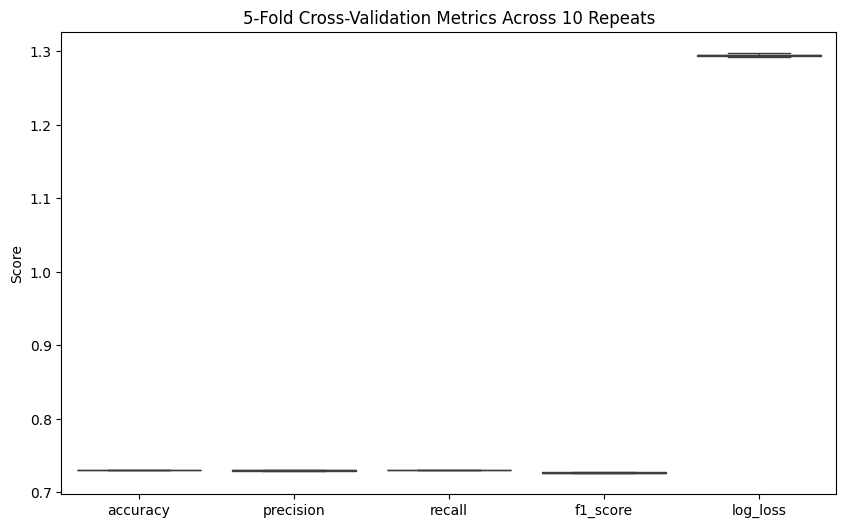

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance

# Fit PCA on the training data only
x_train_pca = pca.fit_transform(x_train_scaled)

# Transform the test data using the PCA model fitted on the training data
x_test_pca = pca.transform(x_test_scaled)

# Convert the result to a DataFrame with proper indexing
x_train_pca = pd.DataFrame(x_train_pca, index=x_train.index)
x_test_pca = pd.DataFrame(x_test_pca, index=x_test.index)

# Ensure all indices are aligned
x_train_pca = x_train_pca.loc[y_train.index]  # Align with y_train

# Double-check if indices match
print("After alignment: x_train_pca and y_train index match:", x_train_pca.index.equals(y_train.index))

# Convert to numpy arrays for cross-validation (if necessary)
x_train_pca_np = x_train_pca.values
y_train_np = y_train.values


print("Are there any NaNs in x_train_pca?:", x_train_pca.isnull().any().any())
print("Are there any NaNs in y_train?:", y_train.isnull().any())

# Check for infinities
print("Are there any infinities in x_train_pca?:", (x_train_pca == np.inf).any().any() or (x_train_pca == -np.inf).any().any())


# Call the cross-validation function
results = perform_cross_validation(x_train_pca_np, y_train, scoring_function)


# Plot graph for non PCA data
plot_cross_validation_results(results)


In [ ]:
#Logistics Regression Execution - without PCA

# Split dataset to x_train, y_train and x_test, y_test
x_train = train_data.drop(columns=['Outcome.Type'])
y_train = train_data['Outcome.Type']
train_id = train_ids

x_test = test_data.drop(columns=['Outcome.Type'])
y_test = test_data['Outcome.Type']
test_id = test_ids

# Example mappings
outcome_type_mapping = {
    'Return to Owner': 1, 'Transfer': 2, 'Adoption': 3, 'Euthanasia': 4,
    'Died': 5, 'Rto-Adopt': 6, 'Disposal': 7, 'Missing': 8,
    'Stolen': 9, 'Relocate': 10, 'Lost': 11, 'Foster': 12,
    'Reclaimed': 13, 'Escaped': 14, 'Released To Wild': 15
}

# Inverse mapping for easier reference later
inv_outcome_type_mapping = {v: k for k, v in outcome_type_mapping.items()}

# Testing variables
train_id = train_id
x_train = x_train
y_train = y_train

test_id = test_id
x_test = x_test
y_test = y_test

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def logistic_regression_predict_proba(x_train, y_train, x_test, max_iter=3000, solver='saga', C=1.0):
    '''
    Trains a Logistic Regression classifier with scaling and regularization,
    returns predicted probabilities for the test set with explicit probabilities for class 0 and 1.

    Parameters:
    x_train: Training features
    y_train: Training labels
    x_test: Test features for which to predict probabilities
    max_iter: Maximum iterations for logistic regression solver
    solver: Optimization algorithm for logistic regression ('lbfgs', 'saga', 'liblinear', etc.)
    C: Inverse regularization strength (higher values indicate weaker regularization)

    Returns:
    predicted_df: A DataFrame with probabilities for class 0 (Not Adopted) and class 1 (Adopted)
    '''

    # Scale the input features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Initialize the Logistic Regression model with custom solver and regularization
    logreg_model = LogisticRegression(random_state=42, max_iter=max_iter, solver=solver, C=C)

    # Train the logistic regression model on the scaled training set
    logreg_model.fit(x_train_scaled, y_train)

    # Predict probabilities on the scaled test set
    y_pred_probs = logreg_model.predict_proba(x_test_scaled)

    # Create a DataFrame for predicted probabilities with custom column names
    predicted_df = pd.DataFrame(y_pred_probs, columns=['Probability of 0 (Not Adopted)', 'Probability of 1 (Adopted)'])

    # Add the animal IDs as a new column at the start
    predicted_df.insert(0, 'Animal_ID', test_id)

    return predicted_df

# Example usage
y_pred_probs = logistic_regression_predict_proba(x_train, y_train, x_test)
print(y_pred_probs.head())



   Probability of 0 (Not Adopted)  Probability of 1 (Adopted)
0                        0.778936                    0.221064
1                        0.478427                    0.521573
2                        0.125031                    0.874969
3                        0.857268                    0.142732
4                        0.832423                    0.167577


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
#Logistics Regression Function - with PCA

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

def logistic_regression_predict_proba_with_pca(x_train, y_train, x_test, n_components=50, max_iter=3000, cv_splits=5):
    '''
    Trains a Logistic Regression classifier on the PCA-transformed training data,
    returns predicted probabilities for the test set with explicit probabilities for class 0 and 1.

    Parameters:
    - x_train: Training features
    - x_test: Test features for which to predict probabilities
    - y_train: Training labels
    - n_components: Number of PCA components to retain
    - max_iter: Maximum iterations for logistic regression solver

    Returns:
    - predicted_df: A DataFrame with probabilities for class 0 (Not Adopted) and class 1 (Adopted)
    '''

    # Step 1: Standardize the data (PCA often requires scaling)
    # scaler = StandardScaler()

    # Fit the scaler on the training data only and then transform both training and test sets
    # x_train_scaled = scaler.fit_transform(x_train)
    # x_test_scaled = scaler.transform(x_test)

    # Step 2: Perform PCA on the training data only
    pca = PCA(n_components=0.95)  # Retain 95% variance or set a fixed number of components

    # Fit PCA on the training data only
    x_train_pca = pca.fit_transform(x_train)

    # Transform the test data using the PCA model fitted on the training data
    x_test_pca = pca.transform(x_test)

    # Step 3: Initialize the Logistic Regression model
    logreg_model = LogisticRegression(random_state=42, max_iter=max_iter)

    # Step 6: Train the logistic regression model on the entire PCA-transformed and scaled training set
    logreg_model.fit(x_train_pca, y_train)

    # Step 7: Predict probabilities on the PCA test set
    y_pred_probs = logreg_model.predict_proba(x_test_pca)

    # Step 8: Create a DataFrame for predicted probabilities with custom column names
    predicted_df = pd.DataFrame(y_pred_probs, columns=['Probability of 0 (Not Adopted)', 'Probability of 1 (Adopted)'])

    # Step 7: Add the animal IDs as a new column at the start
    predicted_df.insert(0, 'Animal_ID', test_id)


    return predicted_df

y_pred_probs = logistic_regression_predict_proba_with_pca(x_train, y_train, x_test, n_components=50)
y_pred_probs.to_csv("y_pred_probs_logreg_with_pca.csv", index=False)
print(y_pred_probs.head())


  Animal_ID  Probability of 0 (Not Adopted)  Probability of 1 (Adopted)
0   A495162                        0.426612                    0.573388
1   A510858                        0.413868                    0.586132
2   A552059                        0.443280                    0.556720
3   A557091                        0.460555                    0.539445
4   A557091                        0.460555                    0.539445
